In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


!pip install --upgrade gensim
!pip install sklearn-crfsuite
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
path = get_tmpfile("word2vec.model")
model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Requirement already up-to-date: gensim in /opt/conda/lib/python3.7/site-packages (3.8.3)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 743 kB 274 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
/kaggle/input/conll-2k-chunking/train.txt
/kaggle/input/conll-2k-chunking/test.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt


In [2]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel
glovemod=loadGloveModel("../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt")


    

Loading Glove Model
400000  words loaded!


In [3]:
ps = PorterStemmer()
ps.stem("unflattering")

'unflatt'

In [4]:
def featuremaker(sent, i):
#     print(len(sent),end=' ')
#     print(i)
    word = sent[i][0]
    wembed=glovemod.get(word.lower(),glovemod['.'])
    features = {
        'bias': 1.0,
        #'word': glovemod.get(word.lower(),glovemod['.']),
        'length':len(word),
        'suffix': word.replace(ps.stem(word),""),
        'allup': word.isupper(),
        #'word.istitle()': word.istitle(),
        'num': word.isdigit(),
        #'postag': postag,
    }
    for j in range(wembed.shape[0]):
        features["cw"+str(j)]=wembed[j]
    
    if i > 0:
        features['BEG']=False
#         print(i)
#         print(len(sent))
        pword = sent[i-1][0]
        #postag1 = sent[i-1][1]
#         features.update({
#             'bias': 1.0,
#         #'word': glovemod.get(word.lower(),glovemod['.']),
        
#         'pword': pword.replace(ps.stem(pword),""),
#         'allup': pword.isupper(),
#         #'word.istitle()': word.istitle(),
#         'num': pword.isdigit(),
#         #'postag': postag,
#         })
        pwembed=glovemod.get(pword.lower(),glovemod['.'])
        for j in range(pwembed.shape[0]):
            features["pw"+str(j)]=pwembed[j]
    else:
        features['BEG'] = True
        features['FIRSTW'] = False
     
    if i > 1:
        features['FIRST']=False
        ppword = sent[i-2][0]
        #postag1 = sent[i-1][1]
#         features.update({
#             'bias': 1.0,
#         #'word': glovemod.get(word.lower(),glovemod['.']),
        
#         'pword': pword.replace(ps.stem(pword),""),
#         'allup': pword.isupper(),
#         #'word.istitle()': word.istitle(),
#         'num': pword.isdigit(),
#         #'postag': postag,
#         })
        ppwembed=glovemod.get(ppword.lower(),glovemod['.'])
        for j in range(ppwembed.shape[0]):
            features["ppw"+str(j)]=ppwembed[j]
    elif i==1:
        features['BEG'] = False
        features['FIRSTW'] =True
    
    if i < len(sent)-1:
        features['EOS']=False
        nword = sent[i+1][0]
        #postag1 = sent[i+1][1]
        nwembed=glovemod.get(nword.lower(),glovemod['.'])
        for j in range(nwembed.shape[0]):
            features["nw"+str(j)]=nwembed[j]
    else:
        features['LBO']=False
        features['EOS']=True
    if i < len(sent)-2:
        nnword = sent[i+2][0]
    #postag1 = sent[i+2][1]
        nnwembed=glovemod.get(nnword.lower(),glovemod['.'])
        for j in range(nnwembed.shape[0]):
            features["nnw"+str(j)]=nnwembed[j]
    elif i==len(sent)-2:
        features['LBO']=True #last but one
        features['EOS'] = False
    
    return features

In [5]:
allsents=[]
currsent=[]
alllabels=[]
currlabels=[]
with open('../input/conll-2k-chunking/train.txt') as f:
    for line1 in f:
        line=line1.strip()
        if line=='':
            allsents.append(currsent)
            currsent=[]
            alllabels.append(currlabels)
            currlabels=[]
        else:
            word,pos,label=line.split(' ')
            label=label.split('-')[0]
            currsent.append((word,pos))
            currlabels.append(label)

In [6]:
print(len(allsents))
print(allsents[0])
print(alllabels[0])

8936
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from', 'IN'), ('July', 'NNP'), ('and', 'CC'), ('August', 'NNP'), ("'s", 'POS'), ('near-record', 'JJ'), ('deficits', 'NNS'), ('.', '.')]
['B', 'B', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'B', 'B', 'I', 'B', 'B', 'O', 'B', 'B', 'B', 'B', 'O', 'B', 'I', 'I', 'B', 'I', 'I', 'B', 'B', 'I', 'I', 'B', 'I', 'I', 'O']


In [7]:
featurevecs=[[featuremaker(x, i) for i in range(len(x))] for x in allsents]

In [8]:
print(len(featurevecs[0]))
print(featurevecs[0][0])
print(len(allsents[0]))

37
{'bias': 1.0, 'length': 10, 'suffix': 'Confidence', 'allup': False, 'num': False, 'cw0': 0.077302, 'cw1': -0.00018937, 'cw2': 0.8387, 'cw3': 0.20843, 'cw4': -0.46457, 'cw5': -0.45787, 'cw6': -0.66374, 'cw7': -0.66416, 'cw8': -0.2801, 'cw9': -0.085663, 'cw10': -0.32772, 'cw11': 0.25464, 'cw12': 0.1398, 'cw13': -0.35881, 'cw14': -0.19752, 'cw15': 0.15318, 'cw16': -0.74729, 'cw17': 0.68835, 'cw18': -0.28251, 'cw19': 0.72509, 'cw20': -0.086946, 'cw21': -0.21989, 'cw22': -0.33677, 'cw23': -0.48913, 'cw24': -0.10411, 'cw25': -0.59435, 'cw26': 0.039405, 'cw27': -0.15273, 'cw28': -0.028062, 'cw29': -0.04846, 'cw30': 0.23935, 'cw31': 0.25693, 'cw32': -0.39366, 'cw33': 0.10686, 'cw34': -0.063259, 'cw35': 0.029051, 'cw36': 0.33233, 'cw37': -0.073553, 'cw38': -0.44181, 'cw39': -0.44814, 'cw40': -0.56927, 'cw41': -0.89644, 'cw42': 0.72106, 'cw43': -0.17789, 'cw44': 0.058613, 'cw45': -0.30369, 'cw46': 0.24458, 'cw47': -0.20632, 'cw48': 0.47854, 'cw49': -1.86, 'cw50': -0.48617, 'cw51': 0.12238, 'c

In [9]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(featurevecs, alllabels)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [10]:
del featurevecs

In [11]:
allsentstest=[]
currsenttest=[]
alllabelstest=[]
currlabelstest=[]
with open('../input/conll-2k-chunking/test.txt') as f:
    for line1 in f:
        line=line1.strip()
        if line=='':
            allsentstest.append(currsenttest)
            currsenttest=[]
            alllabelstest.append(currlabelstest)
            currlabelstest=[]
        else:
            word,pos,label=line.split(' ')
            label=label.split('-')[0]
            currsenttest.append((word,pos))
            currlabelstest.append(label)

In [12]:
featurevecstest=[[featuremaker(x, i) for i in range(len(x))] for x in allsentstest]

In [13]:
labels = list(crf.classes_)
labels.remove('O')
allpreds = crf.predict(featurevecstest)
metrics.flat_f1_score(alllabelstest, allpreds,
                      average='weighted', labels=labels)


0.8461548500882049

In [14]:
import joblib
#joblib.dump(allpreds, 'preds_wopos.pkl') 
joblib.dump(alllabelstest,'preds.pkl')
#clf = joblib.load('filename.pkl') 

['preds.pkl']

In [16]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
def get_report(y_true, y_pred, classes):
    clf_report = classification_report(y_true, y_pred, labels=classes, zero_division=0)
    clf_report = clf_report.replace('\n\n', '\n')
    clf_report = clf_report.replace('micro avg', 'micro_avg')
    clf_report = clf_report.replace('macro avg', 'macro_avg')
    clf_report = clf_report.replace('weighted avg', 'weighted_avg')
    clf_report = clf_report.replace(' / ', '/')
    lines = clf_report.split('\n')

    class_names, plotMat, support = [], [], []
    for line in lines[1:]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        v = [float(x) for x in t[1: len(t) - 1]]
        if len(v) == 1 : v = v * 3
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    plotMat = np.array(plotMat)
    support = np.array(support)
    return class_names, plotMat, support

def get_scores(y_true, y_pred, classes):
    correct, wrong = {}, {}
    for tag in classes:
        correct[tag] = 0
        wrong[tag] = 0
        
    for tag, pred in zip(y_true, y_pred):
        if tag == pred:
            correct[tag] += 1
        else:
            wrong[tag] += 1
            
    scores = []
    total = len(y_true)
    for tag in classes:
        cur = np.array([correct[tag], wrong[tag]])
        scores.append(cur / total)
    return np.array(scores)
    
def plot_confusion_matrix(classes, mat, normalize=True, cmap=plt.cm.Blues):
    cm = np.copy(mat)
    title = 'Confusion Matrix (without normalization)'
    if normalize:
        cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
        title = title.replace('without', 'with')
    plt.clf()    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    thresh = 1 / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if (cm[i, j] > thresh) else "black"
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color=color)
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches="tight", transparent=True)
    plt.show()
    
def plot_clf_report(classes, plotMat, support, cmap=plt.cm.Blues):
    title = 'Classification Report'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(classes[idx], sup) for idx, sup in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)
    thresh = np.max(plotMat) / 2
    thresh = 1 / 2
    for i in range(plotMat.shape[0]):
        for j in range(plotMat.shape[1]):
            color = "white" if (plotMat[i, j] > thresh) else "black"
            plt.text(j, i, format(plotMat[i, j], '.2f'), horizontalalignment="center", color=color, fontsize=14)

    plt.xlabel('Metrics',fontsize=22)
    plt.ylabel('Classes',fontsize=22)
    plt.tight_layout()
    plt.savefig('classification_report.png', bbox_inches="tight", transparent=True)
    plt.show()
    
def plot_tag_scores(classes, scores, normalize=True):
    plt.clf()
    width = 0.45
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_tick_params(labelsize=18, rotation=25)
    ax.yaxis.set_tick_params(labelsize=18)
    range_bar1 = np.arange(len(classes))
    rects1 = ax.bar(range_bar1, tuple(scores[:, 0]), width, color='b')
    rects2 = ax.bar(range_bar1 + width, tuple(scores[:, 1]), width, color='r')

    ax.set_ylabel('Scores',fontsize=22)
    ax.set_title('Tag scores', fontsize=22)
    ax.set_xticks(range_bar1 + width / 2)
    ax.set_xticklabels(classes)

    ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'), fontsize=20)
    plt.legend()
    plt.savefig('tag_scores.png', bbox_inches="tight", transparent=True)
    plt.show()

<Figure size 432x288 with 0 Axes>

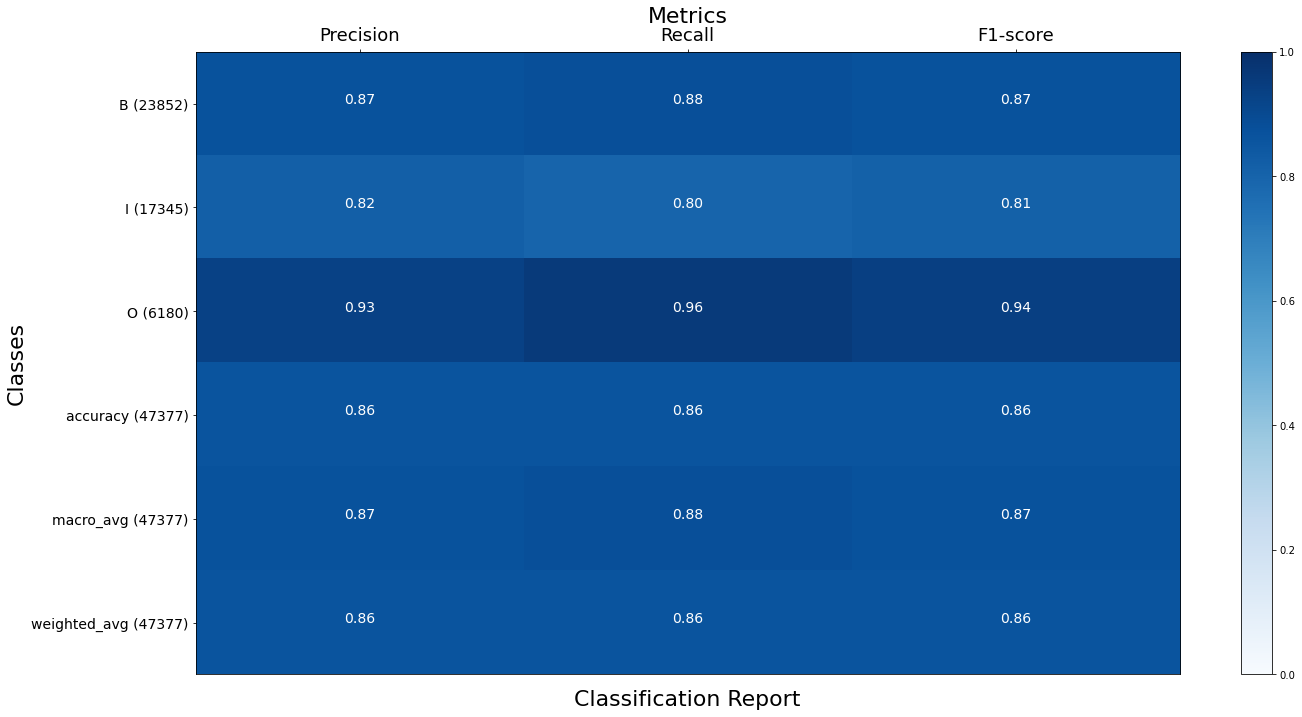

<Figure size 432x288 with 0 Axes>

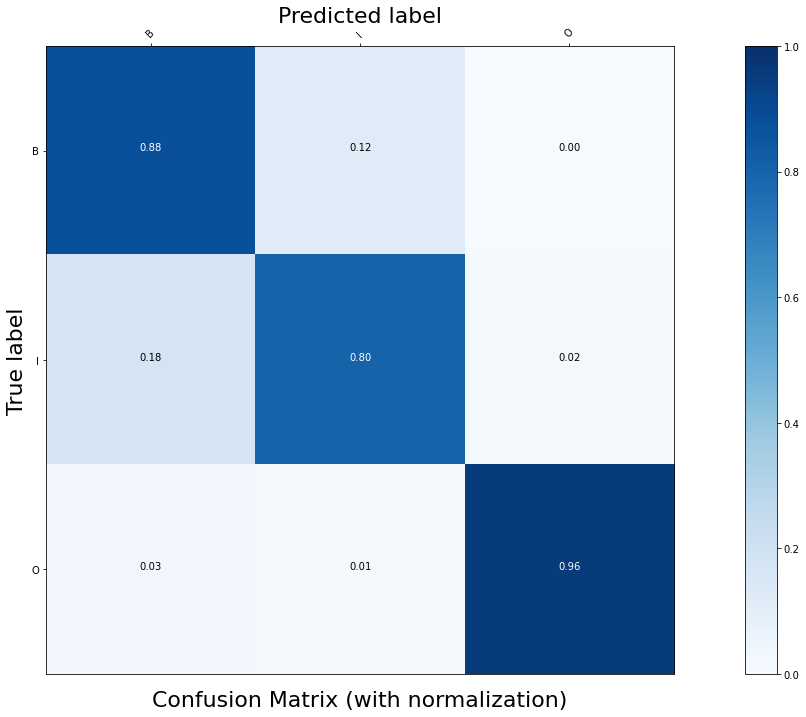

<Figure size 432x288 with 0 Axes>

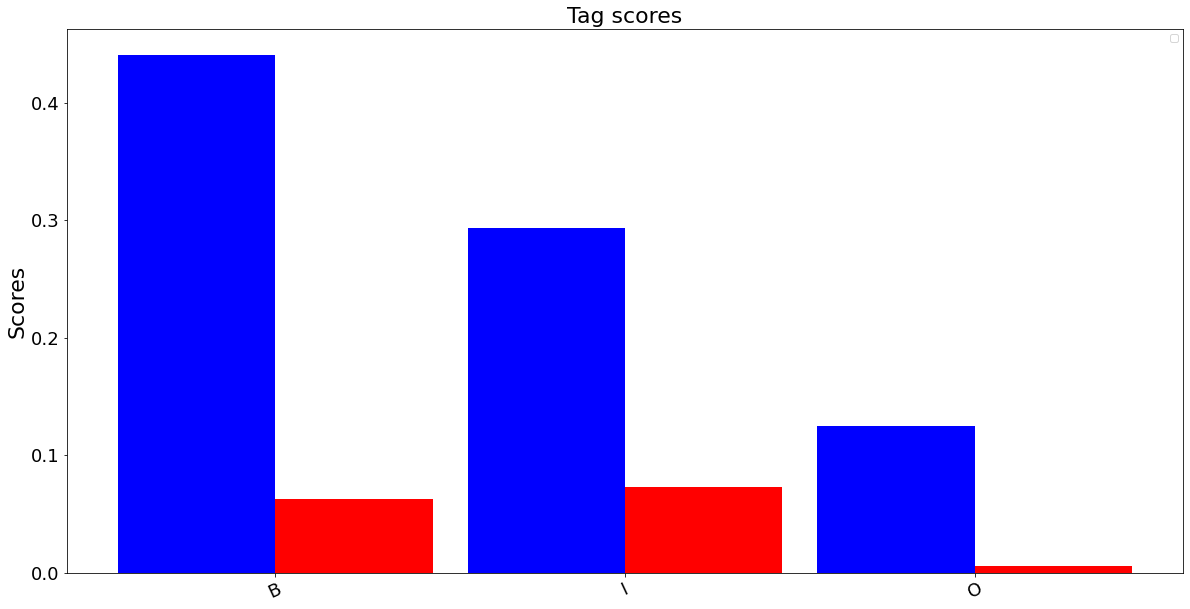

In [17]:
y_true=[x for y in alllabelstest for x in y]
y_pred=[x for y in  allpreds for x in y]
classes = ['B','I','O']
class_names, report, support = get_report(y_true, y_pred, classes)
cm = confusion_matrix(y_true, y_pred, labels=classes)
scores = get_scores(y_true, y_pred, classes)
plot_clf_report(class_names, report, support)
plot_confusion_matrix(classes, cm)
plot_tag_scores(classes, scores)

In [53]:
# allsentstest=[]
# alllabelstest=[]
errswords=[]
correctlabels=[]
errlabels=[]
for x,y,z in zip(allsentstest,alllabelstest,allpreds):
    for i in range(len(y)):
        if y[i]!=z[i]:
#             print('lol')
            errswords.append([x[i-1] if i>0 else '##',x[i],x[i+1] if i<len(x)-1 else '##'])
            correctlabels.append([y[i-1] if i>0 else '##',y[i],y[i+1] if i<len(y)-1 else '##'])
            errlabels.append([z[i-1] if i>0 else '##',z[i],z[i+1] if i<len(z)-1 else '##'])

In [54]:
# print(errswords)

In [55]:
# [print((str(i[0][0])  if i[0][0]!=None else '##' )+' '+str(i[1][0])+' '+(str(i[2][0])  if i[2][0]!=None else '##' )+' ( correct: '+j[0]+' '+j[1]+' '+j[2]+ ' predicted: '+k[0]+' '+k[1]+' '+k[2]+' )') for i,j,k in zip(errswords[:100],correctlabels[:100],errlabels[:100])]

provide structural parts ( correct: I B I predicted: I I B )
structural parts for ( correct: B I B predicted: I B B )
agreement calls for ( correct: I B B predicted: I I B )
These include , ( correct: B B O predicted: B I O )
each jetliner 's ( correct: B I B predicted: B B B )
pressure floor , ( correct: I I O predicted: I B O )
fixed leading edges ( correct: B I I predicted: B B B )
leading edges for ( correct: I I B predicted: B B B )
keel beam . ( correct: I I O predicted: I B O )
has already delivered ( correct: B I I predicted: B B B )
already delivered 793 ( correct: I I B predicted: B B I )
delivered 793 of ( correct: I B B predicted: B I B )
to Boeing . ( correct: B B O predicted: B I O )
aerospace , electronics ( correct: I I I predicted: I O B )
, electronics , ( correct: I I I predicted: O B O )
electronics , automotive ( correct: I I I predicted: B O B )
, automotive and ( correct: I I I predicted: O B O )
automotive and graphics ( correct: I I I predicted: B O B )
and gra

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]